In [ ]:
#!pip install tensorflow --user --upgrade
#!pip install keras --user --upgrade

In [ ]:
#pip install --upgrade ipykernel
#pip install autocorrect
#pip install textblob
#pip install gensim==3.8.3
#!pip install pyLDAvis
#pip install spacy

In [ ]:
#!type -a pip

In [1]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import regex as re
import scipy, gensim, spacy, logging

import matplotlib.pyplot as plt

from autocorrect import Speller
from sklearn.feature_extraction.text import TfidfVectorizer
from textblob import TextBlob

import gensim.corpora as corpora
from gensim.utils import lemmatize, simple_preprocess
from gensim.models import CoherenceModel
from gensim.models import CoherenceModel
import gensim.corpora as corpora

import pyLDAvis
import pyLDAvis.gensim_models

import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\quant\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
merged = pd.read_csv("merged_new.csv")
merged.Content

0     This paper aims to compute the performances of...
1     Renewable energy project development is highly...
2     This study assesses the factors responsible fo...
3     An empirical analysis of the non-linear impact...
4     Climate change is increasingly recognized worl...
                            ...                        
82    This paper analyses the politics of renewable ...
83    Expansion of renewable energies is a central p...
84    Stakeholders strongly influence project succes...
85    This paper aims to analyse reasons for the abs...
86    Citizens own nearly half the renewable energy ...
Name: Content, Length: 87, dtype: object

In [3]:
#display word count
merged['word_count'] = merged['Content'].apply(lambda x: len(str(x).split(" ")))
merged[['Content','word_count']].head()

,Content,word_count
0,This paper aims to compute the performances of...,777
1,Renewable energy project development is highly...,768
2,This study assesses the factors responsible fo...,817
3,An empirical analysis of the non-linear impact...,27
4,Climate change is increasingly recognized worl...,490


In [4]:
merged[['Content','word_count']]

,Content,word_count
0,This paper aims to compute the performances of...,777
1,Renewable energy project development is highly...,768
2,This study assesses the factors responsible fo...,817
3,An empirical analysis of the non-linear impact...,27
4,Climate change is increasingly recognized worl...,490
...,...,...
82,This paper analyses the politics of renewable ...,571
83,Expansion of renewable energies is a central p...,970
84,Stakeholders strongly influence project succes...,795
85,This paper aims to analyse reasons for the abs...,1228


In [5]:
merged[['Content','word_count']].sum()

Content       This paper aims to compute the performances of...
word_count                                                75311
dtype: object

# Data prep

In [6]:
#lowercase content
merged['Content'] = merged['Content'].apply(lambda x: " ".join(x.lower() for x in x.split()))
merged['Content'].head()

0    this paper aims to compute the performances of...
1    renewable energy project development is highly...
2    this study assesses the factors responsible fo...
3    an empirical analysis of the non-linear impact...
4    climate change is increasingly recognized worl...
Name: Content, dtype: object

In [7]:
#remove punctuations
merged['Content'] = merged['Content'].str.replace('[^\w\s]','')
merged['Content'].head()

<>:2: DeprecationWarning: invalid escape sequence \w
<>:2: DeprecationWarning: invalid escape sequence \w
<>:2: DeprecationWarning: invalid escape sequence \w
C:\Users\quant\AppData\Local\Temp\ipykernel_19416\509571761.py:2: DeprecationWarning: invalid escape sequence \w
  merged['Content'] = merged['Content'].str.replace('[^\w\s]','')


0    this paper aims to compute the performances of...
1    renewable energy project development is highly...
2    this study assesses the factors responsible fo...
3    an empirical analysis of the nonlinear impacts...
4    climate change is increasingly recognized worl...
Name: Content, dtype: object

In [8]:
#display number of stopwords

from nltk.corpus import stopwords
stop = stopwords.words('english')

merged['stopwords'] = merged['Content'].apply(lambda x: len([x for x in x.split() if x in stop]))
merged[['Content','stopwords']].head()

,Content,stopwords
0,this paper aims to compute the performances of...,319
1,renewable energy project development is highly...,315
2,this study assesses the factors responsible fo...,277
3,an empirical analysis of the nonlinear impacts...,7
4,climate change is increasingly recognized worl...,179


In [9]:
print(stop)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

In [10]:
#remove stopwords
stop = stopwords.words('english')
merged['Content'] = merged['Content'].apply(lambda x: " ".join(x for x in x.split() if x not in stop))
merged['Content'].head()

0    paper aims compute performances smaller versio...
1    renewable energy project development highly co...
2    study assesses factors responsible success fai...
3    empirical analysis nonlinear impacts icttrade ...
4    climate change increasingly recognized worldwi...
Name: Content, dtype: object

# Exploratory analysis 

In [11]:
TextBlob(merged['Content'][0]).ngrams(2)

[WordList(['paper', 'aims']),
 WordList(['aims', 'compute']),
 WordList(['compute', 'performances']),
 WordList(['performances', 'smaller']),
 WordList(['smaller', 'version']),
 WordList(['version', 'solana']),
 WordList(['solana', 'power']),
 WordList(['power', 'plant']),
 WordList(['plant', 'half']),
 WordList(['half', 'solar']),
 WordList(['solar', 'field']),
 WordList(['field', '1']),
 WordList(['1', '2']),
 WordList(['2', 'turbines']),
 WordList(['turbines', 'power']),
 WordList(['power', 'cycle']),
 WordList(['cycle', 'built']),
 WordList(['built', 'amman']),
 WordList(['amman', 'maan']),
 WordList(['maan', 'jordan']),
 WordList(['jordan', 'climate']),
 WordList(['climate', 'conditions']),
 WordList(['conditions', 'amman']),
 WordList(['amman', 'maan']),
 WordList(['maan', 'discussed']),
 WordList(['discussed', 'thoroughly']),
 WordList(['thoroughly', 'paper']),
 WordList(['paper', 'furthermore']),
 WordList(['furthermore', 'preliminary']),
 WordList(['preliminary', 'validation']

In [12]:
TextBlob(merged['Content'][0]).ngrams(3)

[WordList(['paper', 'aims', 'compute']),
 WordList(['aims', 'compute', 'performances']),
 WordList(['compute', 'performances', 'smaller']),
 WordList(['performances', 'smaller', 'version']),
 WordList(['smaller', 'version', 'solana']),
 WordList(['version', 'solana', 'power']),
 WordList(['solana', 'power', 'plant']),
 WordList(['power', 'plant', 'half']),
 WordList(['plant', 'half', 'solar']),
 WordList(['half', 'solar', 'field']),
 WordList(['solar', 'field', '1']),
 WordList(['field', '1', '2']),
 WordList(['1', '2', 'turbines']),
 WordList(['2', 'turbines', 'power']),
 WordList(['turbines', 'power', 'cycle']),
 WordList(['power', 'cycle', 'built']),
 WordList(['cycle', 'built', 'amman']),
 WordList(['built', 'amman', 'maan']),
 WordList(['amman', 'maan', 'jordan']),
 WordList(['maan', 'jordan', 'climate']),
 WordList(['jordan', 'climate', 'conditions']),
 WordList(['climate', 'conditions', 'amman']),
 WordList(['conditions', 'amman', 'maan']),
 WordList(['amman', 'maan', 'discussed

In [13]:
freq = pd.Series(' '.join(merged['Content']).split()).value_counts()[:20]
freq

energy           1174
renewable         684
policy            387
project           294
success           280
projects          256
factors           249
development       223
also              222
study             205
important         198
research          193
community         170
technology        169
support           164
local             152
different         148
stakeholders      136
policies          135
environmental     135
dtype: int64

In [14]:
#add new stop words

stop = stopwords.words('english')
newStopWords = ['also','1','2','3','4','turkey','et','al','csfs','different','jordan','maan','anman','important','results','however','paper','new','implications','research','may','factors','study','success','this''csf','project','finding','result','decision','impact''important','solar','wind','renewable','energy','factors','projects','success','study']
stop.extend(newStopWords)

merged['Content'] = merged['Content'].apply(lambda x: " ".join(x for x in x.split() if x not in stop))
merged['Content'].head()


0    aims compute performances smaller version sola...
1    development highly complex means guaranteed de...
2    assesses responsible failure access programs b...
3    empirical analysis nonlinear impacts icttrade ...
4    climate change increasingly recognized worldwi...
Name: Content, dtype: object

In [15]:
freq = pd.Series(' '.join(merged['Content']).split()).value_counts()[:20]
freq

policy           387
development      223
community        170
technology       169
support          164
local            152
stakeholders     136
environmental    135
policies         135
analysis         130
financial        124
government       123
role             120
economic         118
technologies     114
sector           113
social           109
one              104
power            103
use              101
dtype: int64

In [16]:
TextBlob(merged['Content'][0]).ngrams(2)

[WordList(['aims', 'compute']),
 WordList(['compute', 'performances']),
 WordList(['performances', 'smaller']),
 WordList(['smaller', 'version']),
 WordList(['version', 'solana']),
 WordList(['solana', 'power']),
 WordList(['power', 'plant']),
 WordList(['plant', 'half']),
 WordList(['half', 'field']),
 WordList(['field', 'turbines']),
 WordList(['turbines', 'power']),
 WordList(['power', 'cycle']),
 WordList(['cycle', 'built']),
 WordList(['built', 'amman']),
 WordList(['amman', 'climate']),
 WordList(['climate', 'conditions']),
 WordList(['conditions', 'amman']),
 WordList(['amman', 'discussed']),
 WordList(['discussed', 'thoroughly']),
 WordList(['thoroughly', 'furthermore']),
 WordList(['furthermore', 'preliminary']),
 WordList(['preliminary', 'validation']),
 WordList(['validation', 'exercise']),
 WordList(['exercise', 'performed']),
 WordList(['performed', 'using']),
 WordList(['using', 'measured']),
 WordList(['measured', 'monthly']),
 WordList(['monthly', 'average']),
 WordList

In [17]:
TextBlob(merged['Content'][0]).ngrams(3)

[WordList(['aims', 'compute', 'performances']),
 WordList(['compute', 'performances', 'smaller']),
 WordList(['performances', 'smaller', 'version']),
 WordList(['smaller', 'version', 'solana']),
 WordList(['version', 'solana', 'power']),
 WordList(['solana', 'power', 'plant']),
 WordList(['power', 'plant', 'half']),
 WordList(['plant', 'half', 'field']),
 WordList(['half', 'field', 'turbines']),
 WordList(['field', 'turbines', 'power']),
 WordList(['turbines', 'power', 'cycle']),
 WordList(['power', 'cycle', 'built']),
 WordList(['cycle', 'built', 'amman']),
 WordList(['built', 'amman', 'climate']),
 WordList(['amman', 'climate', 'conditions']),
 WordList(['climate', 'conditions', 'amman']),
 WordList(['conditions', 'amman', 'discussed']),
 WordList(['amman', 'discussed', 'thoroughly']),
 WordList(['discussed', 'thoroughly', 'furthermore']),
 WordList(['thoroughly', 'furthermore', 'preliminary']),
 WordList(['furthermore', 'preliminary', 'validation']),
 WordList(['preliminary', 'valid

In [18]:
merged=merged.drop(['Title','word_count','stopwords'],axis =1)


In [19]:
merged

,Content
0,aims compute performances smaller version sola...
1,development highly complex means guaranteed de...
2,assesses responsible failure access programs b...
3,empirical analysis nonlinear impacts icttrade ...
4,climate change increasingly recognized worldwi...
...,...
82,analyses politics discussing opportunities wel...
83,expansion energies central pillar german trans...
84,stakeholders strongly influence particularly c...
85,aims analyse reasons absence electricity impor...


# Data prep

In [20]:
#tokenization
TextBlob(merged['Content'][1]).words

#lemmatization
from textblob import Word
merged['Content'] = merged['Content'].apply(lambda x: " ".join([Word(word).lemmatize() for word in x.split()]))
merged['Content'].head()

0    aim compute performance smaller version solana...
1    development highly complex mean guaranteed dec...
2    ass responsible failure access program banglad...
3    empirical analysis nonlinear impact icttrade o...
4    climate change increasingly recognized worldwi...
Name: Content, dtype: object

# LDA Model - Gensim
#source: 
https://towardsdatascience.com/evaluate-topic-model-in-python-latent-dirichlet-allocation-lda-7d57484bb5d0
https://www.machinelearningplus.com/nlp/topic-modeling-visualization-how-to-present-results-lda-models/

In [21]:
merged_content = [text.split(" ") for text in merged.Content]
merged_content

[['aim',
  'compute',
  'performance',
  'smaller',
  'version',
  'solana',
  'power',
  'plant',
  'half',
  'field',
  'turbine',
  'power',
  'cycle',
  'built',
  'amman',
  'climate',
  'condition',
  'amman',
  'discussed',
  'thoroughly',
  'furthermore',
  'preliminary',
  'validation',
  'exercise',
  'performed',
  'using',
  'measured',
  'monthly',
  'average',
  'value',
  'electricity',
  'production',
  'existing',
  'plant',
  'system',
  'advisor',
  'model',
  'sam',
  'used',
  'predict',
  'performance',
  'proposed',
  'solanalike',
  'plant',
  'amman',
  'validation',
  'show',
  'good',
  'agreement',
  'measured',
  'data',
  'existing',
  'power',
  'plant',
  'simulation',
  'including',
  'monthly',
  'capacity',
  'suggest',
  'annual',
  'operation',
  'maybe',
  'even',
  'better',
  'operation',
  'gila',
  'bend',
  'annual',
  'average',
  'capacity',
  'factor',
  '41',
  'v',
  'capacity',
  'factor',
  '39',
  'gila',
  'bend',
  'mainly',
  'due',

In [22]:
# only keep words above 10 counts
from gensim.corpora.dictionary import Dictionary
dictionary = Dictionary(merged_content)
dictionary.filter_extremes(no_below=10)

In [23]:
# Create Dictionary
id2word = corpora.Dictionary(merged_content)
# Create Corpus
texts = merged_content
# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]
# View
print(corpus[:1])


[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 2), (9, 2), (10, 2), (11, 1), (12, 1), (13, 1), (14, 1), (15, 1), (16, 1), (17, 1), (18, 1), (19, 1), (20, 1), (21, 1), (22, 1), (23, 1), (24, 1), (25, 1), (26, 2), (27, 7), (28, 4), (29, 1), (30, 1), (31, 1), (32, 4), (33, 4), (34, 1), (35, 6), (36, 1), (37, 1), (38, 3), (39, 1), (40, 12), (41, 2), (42, 2), (43, 1), (44, 1), (45, 1), (46, 1), (47, 1), (48, 1), (49, 1), (50, 1), (51, 4), (52, 1), (53, 1), (54, 1), (55, 1), (56, 1), (57, 12), (58, 1), (59, 1), (60, 3), (61, 1), (62, 1), (63, 1), (64, 2), (65, 1), (66, 3), (67, 1), (68, 1), (69, 1), (70, 1), (71, 1), (72, 1), (73, 1), (74, 2), (75, 2), (76, 1), (77, 1), (78, 2), (79, 1), (80, 1), (81, 2), (82, 5), (83, 2), (84, 1), (85, 1), (86, 1), (87, 1), (88, 1), (89, 1), (90, 2), (91, 1), (92, 1), (93, 1), (94, 1), (95, 2), (96, 3), (97, 2), (98, 1), (99, 2), (100, 1), (101, 1), (102, 1), (103, 3), (104, 1), (105, 1), (106, 4), (107, 1), (108, 1), (109, 2), (110, 

In [24]:
## create LDA model
from gensim.models.ldamodel import LdaModel
lda_model = LdaModel(corpus=corpus, id2word=id2word,
                    num_topics=5, random_state=100,
                    chunksize=100, passes=10,
                     per_word_topics=True)
from pprint import pprint
# Print the Keyword in the topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus] 

# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=merged_content, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)

# Compute Coherence Score using UMass
coherence_Um_model_lda = CoherenceModel(model=lda_model, texts=merged_content, dictionary=dictionary, coherence="u_mass")
coherence_Um_lda = coherence_Um_model_lda.get_coherence()
print('\nUMassCoherence Score: ', coherence_Um_lda)

## presentation -- final graph or word cloud per topic
## repeating words - see the LDA visualisation - it doesnt match the index here. 
## see topic 0 and 1 are well seperated - new random numbering, look at the top few words to match the grouping.
## add another model - final report - how well seperated the topics are.. clustering. see LSA and PLSA

[(0,
  '0.014*"policy" + 0.009*"investment" + 0.009*"community" + 0.007*"financial" '
  '+ 0.007*"performance" + 0.007*"investor" + 0.006*"system" + '
  '0.006*"institutional" + 0.006*"technology" + 0.006*"measure"'),
 (1,
  '0.017*"policy" + 0.007*"technology" + 0.007*"industry" + 0.004*"government" '
  '+ 0.004*"environmental" + 0.004*"adoption" + 0.004*"level" + 0.004*"role" + '
  '0.004*"support" + 0.004*"development"'),
 (2,
  '0.010*"policy" + 0.009*"stakeholder" + 0.009*"community" + '
  '0.008*"development" + 0.006*"process" + 0.005*"local" + 0.005*"management" '
  '+ 0.004*"support" + 0.004*"government" + 0.004*"technology"'),
 (3,
  '0.008*"technology" + 0.007*"policy" + 0.006*"system" + 0.005*"development" '
  '+ 0.005*"community" + 0.005*"traceability" + 0.005*"group" + 0.004*"social" '
  '+ 0.004*"support" + 0.004*"case"'),
 (4,
  '0.009*"state" + 0.007*"policy" + 0.006*"technology" + 0.005*"investor" + '
  '0.005*"expansion" + 0.005*"government" + 0.005*"plant" + 0.005*"c

# LDA Mallet

In [25]:
#use Mallet to improve LDA cohrence score.
mallet_path = r'C:\Users\quant\Desktop\Janine ANL488 files\mallet-2.0.8\bin\mallet.bat' # update this path
ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=5, id2word=id2word)

pprint(ldamallet.show_topics(formatted=False))

# Compute Coherence Score
coherence_model_ldamallet = CoherenceModel(model=ldamallet, texts=merged_content, dictionary=id2word, coherence='c_v')
coherence_ldamallet = coherence_model_ldamallet.get_coherence()
print('\nCoherence Score: ', coherence_ldamallet)


CalledProcessError: Command 'C:\Users\quant\Desktop\Janine ANL488 files\mallet-2.0.8\bin\mallet.bat import-file --preserve-case --keep-sequence --remove-stopwords --token-regex "\S+" --input C:\Users\quant\AppData\Local\Temp\e68e2a_corpus.txt --output C:\Users\quant\AppData\Local\Temp\e68e2a_corpus.mallet' returned non-zero exit status 1.

# LDA Gensim Visualizations

In [26]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_model, corpus, id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1      0.009345  0.015802       1        1  29.923751
2      0.078401 -0.002189       2        1  26.349719
3      0.047198  0.036237       3        1  22.155179
4     -0.037144 -0.108179       4        1  11.186610
0     -0.097800  0.058329       5        1  10.384742, topic_info=               Term        Freq       Total Category  logprob  loglift
1447          state  105.000000  105.000000  Default  30.0000  30.0000
361        investor   79.000000   79.000000  Default  29.0000  29.0000
500       community  212.000000  212.000000  Default  28.0000  28.0000
596      investment  140.000000  140.000000  Default  27.0000  27.0000
392          policy  458.000000  458.000000  Default  26.0000  26.0000
...             ...         ...         ...      ...      ...      ...
515         country   15.203085  122.398088   Topic5  -5.6169   0.1791
309     development   15.418892  206.194566   Topic5  -5.6028  -0.3284
80         economic   13.993547  103.406522   Topic5  -5.6998   0.2648
83    environmental   13.252607  118.870407   Topic5  -5.7542   0.0710
785          effect   12.469470   68.769247   Topic5  -5.8151   0.5574

[387 rows x 6 columns], token_table=      Topic      Freq    Term
term                         
3609      5  0.814829     001
3613      5  0.814853     058
1609      5  0.814817    1980
4807      2  0.807160    2020
4807      4  0.142440    2020
...     ...       ...     ...
448       4  0.047153  within
448       5  0.078588  within
1912      2  0.936371   woody
4448      4  0.972651     wtp
3702      5  0.884156       β

[806 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 3, 4, 5, 1])

In [27]:
#making Coherence graph
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values
# Can take a long time to run.
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=merged_content, start=2, limit=15, step=1)


CalledProcessError: Command 'C:\Users\quant\Desktop\Janine ANL488 files\mallet-2.0.8\bin\mallet.bat import-file --preserve-case --keep-sequence --remove-stopwords --token-regex "\S+" --input C:\Users\quant\AppData\Local\Temp\3ea6b9_corpus.txt --output C:\Users\quant\AppData\Local\Temp\3ea6b9_corpus.mallet' returned non-zero exit status 1.

In [28]:
# Show graph
limit=15; start=2; step=1;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.title ("")
plt.show()

NameError: name 'coherence_values' is not defined

In [29]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

NameError: name 'coherence_values' is not defined

In [30]:
def format_topics_sentences(ldamodel=None, corpus=corpus, texts=merged_content):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list            
        # print(row)
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=merged_content)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
df_dominant_topic.head(30)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,4.0,0.9980,"state, policy, technology, investor, expansion...","[aim, compute, performance, smaller, version, ..."
1,1,2.0,0.9980,"policy, stakeholder, community, development, p...","[development, highly, complex, mean, guarantee..."
2,2,4.0,0.8502,"state, policy, technology, investor, expansion...","[ass, responsible, failure, access, program, b..."
3,3,1.0,0.9514,"policy, technology, industry, government, envi...","[empirical, analysis, nonlinear, impact, icttr..."
4,4,1.0,0.9971,"policy, technology, industry, government, envi...","[climate, change, increasingly, recognized, wo..."
5,5,3.0,0.9987,"technology, policy, system, development, commu...","[key, stakeholder, industry, highly, responsib..."
6,6,3.0,0.9325,"technology, policy, system, development, commu...","[bioenergy, village, region, germany, intervie..."
7,7,2.0,0.9967,"policy, stakeholder, community, development, p...","[photovoltaics, pv, deployment, easy, dense, u..."
8,8,3.0,0.9991,"technology, policy, system, development, commu...","[contribution, environmental, group, technolog..."
9,9,0.0,0.9486,"policy, investment, community, financial, perf...","[combining, feedin, tarifis, netmetering, sche..."


In [31]:
# Display setting to show more characters in column
pd.options.display.max_colwidth = 100

sent_topics_sorteddf_mallet = pd.DataFrame()
sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=False).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Representative Text"]

# Show
sent_topics_sorteddf_mallet.head(10)



,Topic_Num,Topic_Perc_Contrib,Keywords,Representative Text
0,0.0,0.9991,"policy, investment, community, financial, performance, investor, system, institutional, technolo...","[community, initiative, emerging, across, europe, varying, number, rate, strategy, literature, o..."
1,1.0,0.9990,"policy, technology, industry, government, environmental, adoption, level, role, support, develop...","[contrast, two, national, home, system, shs, program, relied, world, bank, approach, reached, dr..."
2,2.0,0.9995,"policy, stakeholder, community, development, process, local, management, support, government, te...","[evaluating, sustainable, operation, communityowned, communityoperated, complex, development, of..."
3,3.0,0.9991,"technology, policy, system, development, community, traceability, group, social, support, case","[contribution, environmental, group, technology, adoption, diffusion, dominant, incumbent, build..."
4,4.0,0.9988,"state, policy, technology, investor, expansion, government, plant, country, electricity, community","[aim, analyse, reason, absence, electricity, import, european, union, author, develop, multileve..."


In [32]:
doc_lens = [len(d) for d in df_dominant_topic.Text]

# Plot
plt.figure(figsize=(16,7), dpi=160)
plt.hist(doc_lens, bins = 1000, color='navy')
plt.text(750, 100, "Mean   : " + str(round(np.mean(doc_lens))))
plt.text(750,  90, "Median : " + str(round(np.median(doc_lens))))
plt.text(750,  80, "Stdev   : " + str(round(np.std(doc_lens))))
plt.text(750,  70, "1%ile    : " + str(round(np.quantile(doc_lens, q=0.01))))
plt.text(750,  60, "99%ile  : " + str(round(np.quantile(doc_lens, q=0.99))))

plt.gca().set(xlim=(0, 1000), ylabel='Number of Documents', xlabel='Document Word Count')
plt.tick_params(size=16)
plt.xticks(np.linspace(0,1000,9))
plt.title('Distribution of Document Word Counts', fontdict=dict(size=22))
plt.show()

In [33]:
import seaborn as sns
import matplotlib.colors as mcolors


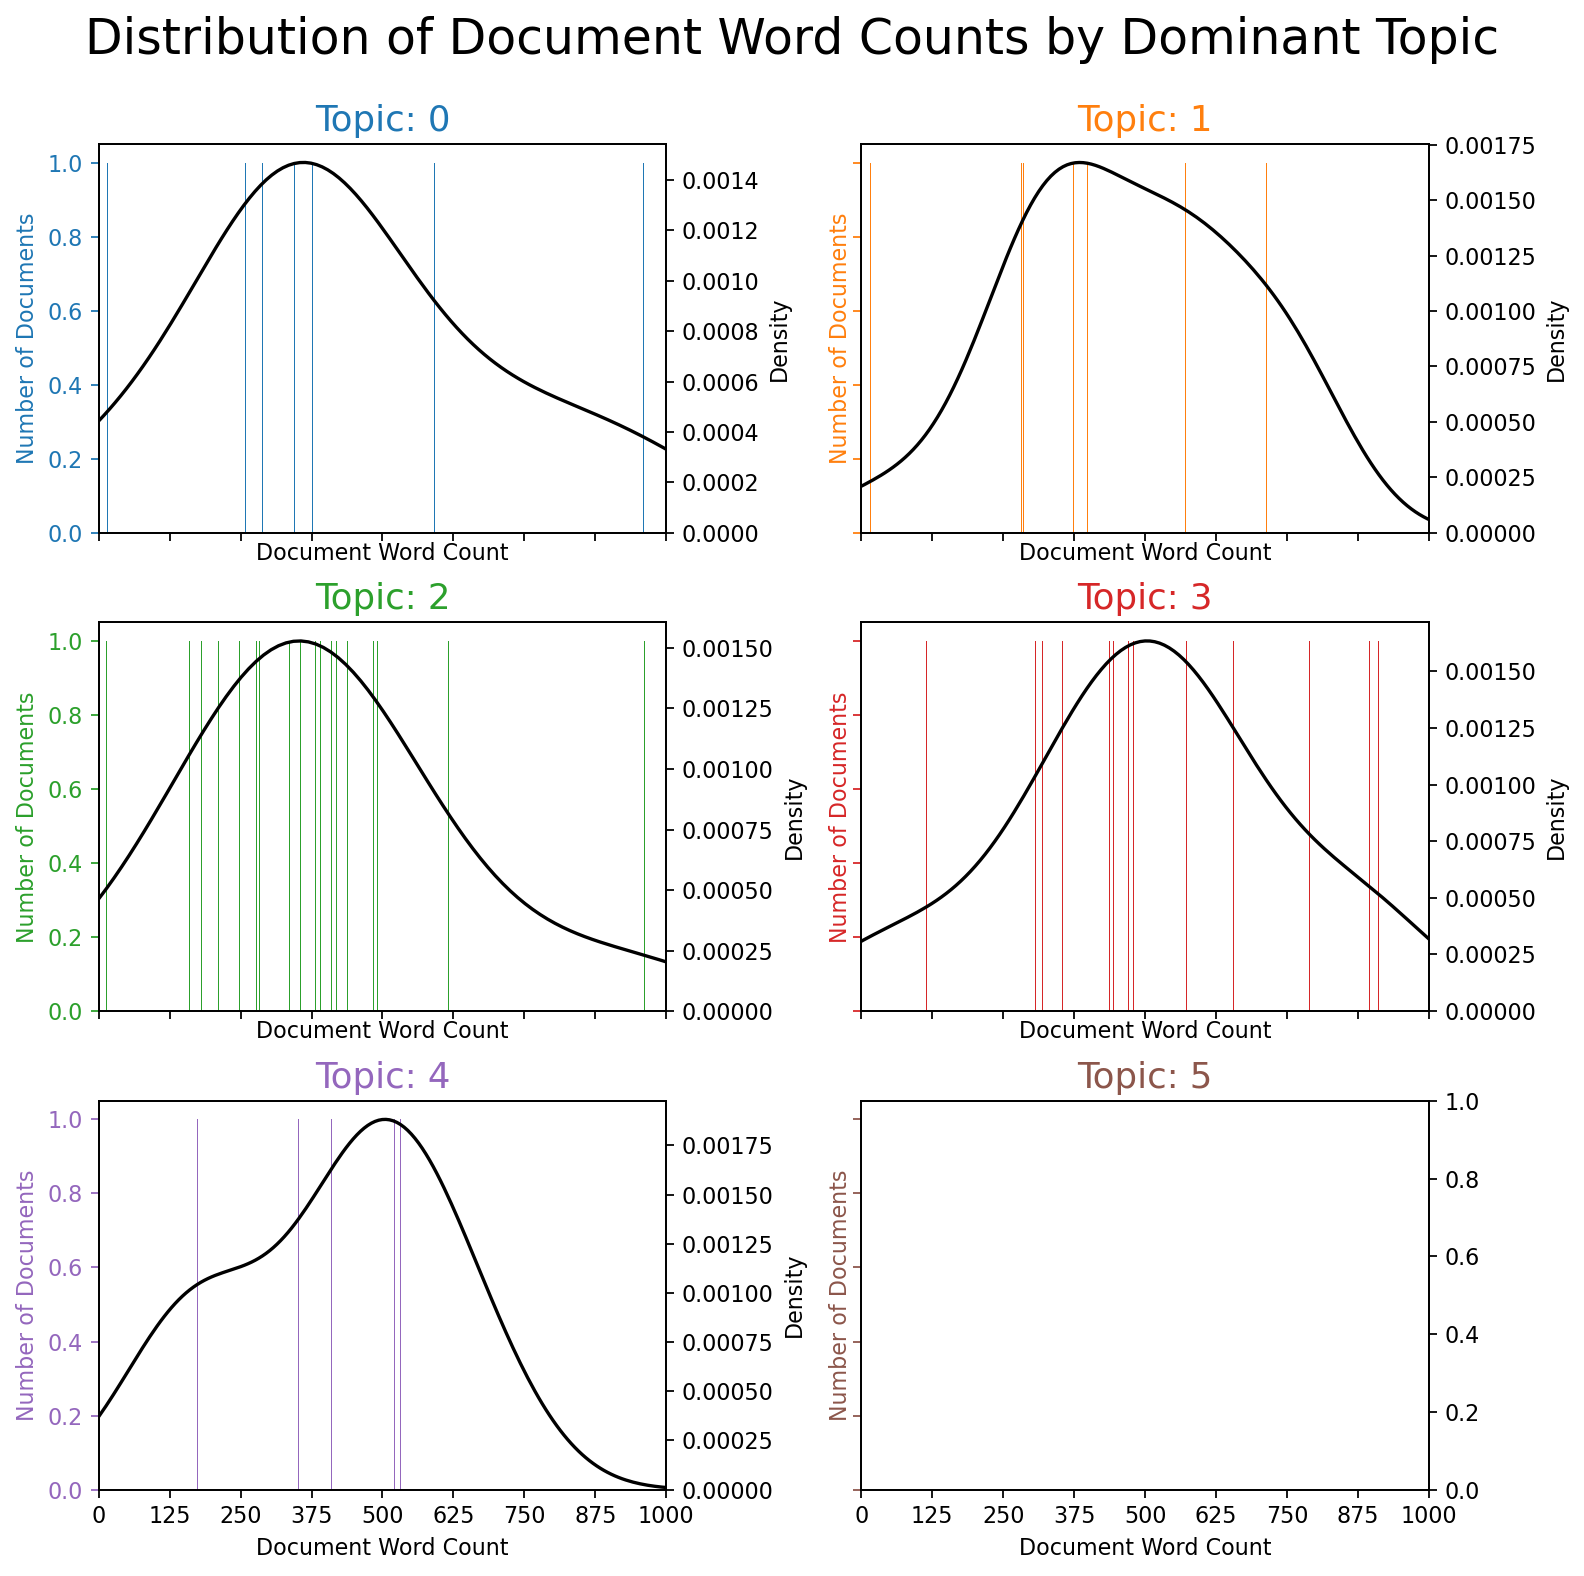

In [35]:
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

fig, axes = plt.subplots(3,2,figsize=(10,10), dpi=160, sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):    
    df_dominant_topic_sub = df_dominant_topic.loc[df_dominant_topic.Dominant_Topic == i, :]
    doc_lens = [len(d) for d in df_dominant_topic_sub.Text]
    ax.hist(doc_lens, bins = 1000, color=cols[i])
    ax.tick_params(axis='y', labelcolor=cols[i], color=cols[i])
    sns.kdeplot(doc_lens, color="black", shade=False, ax=ax.twinx())
    ax.set(xlim=(0, 1000), xlabel='Document Word Count')
    ax.set_ylabel('Number of Documents', color=cols[i])
    ax.set_title('Topic: '+str(i), fontdict=dict(size=16, color=cols[i]))

fig.tight_layout()
fig.subplots_adjust(top=0.90)
plt.xticks(np.linspace(0,1000,9))
fig.suptitle('Distribution of Document Word Counts by Dominant Topic', fontsize=22)
plt.show()

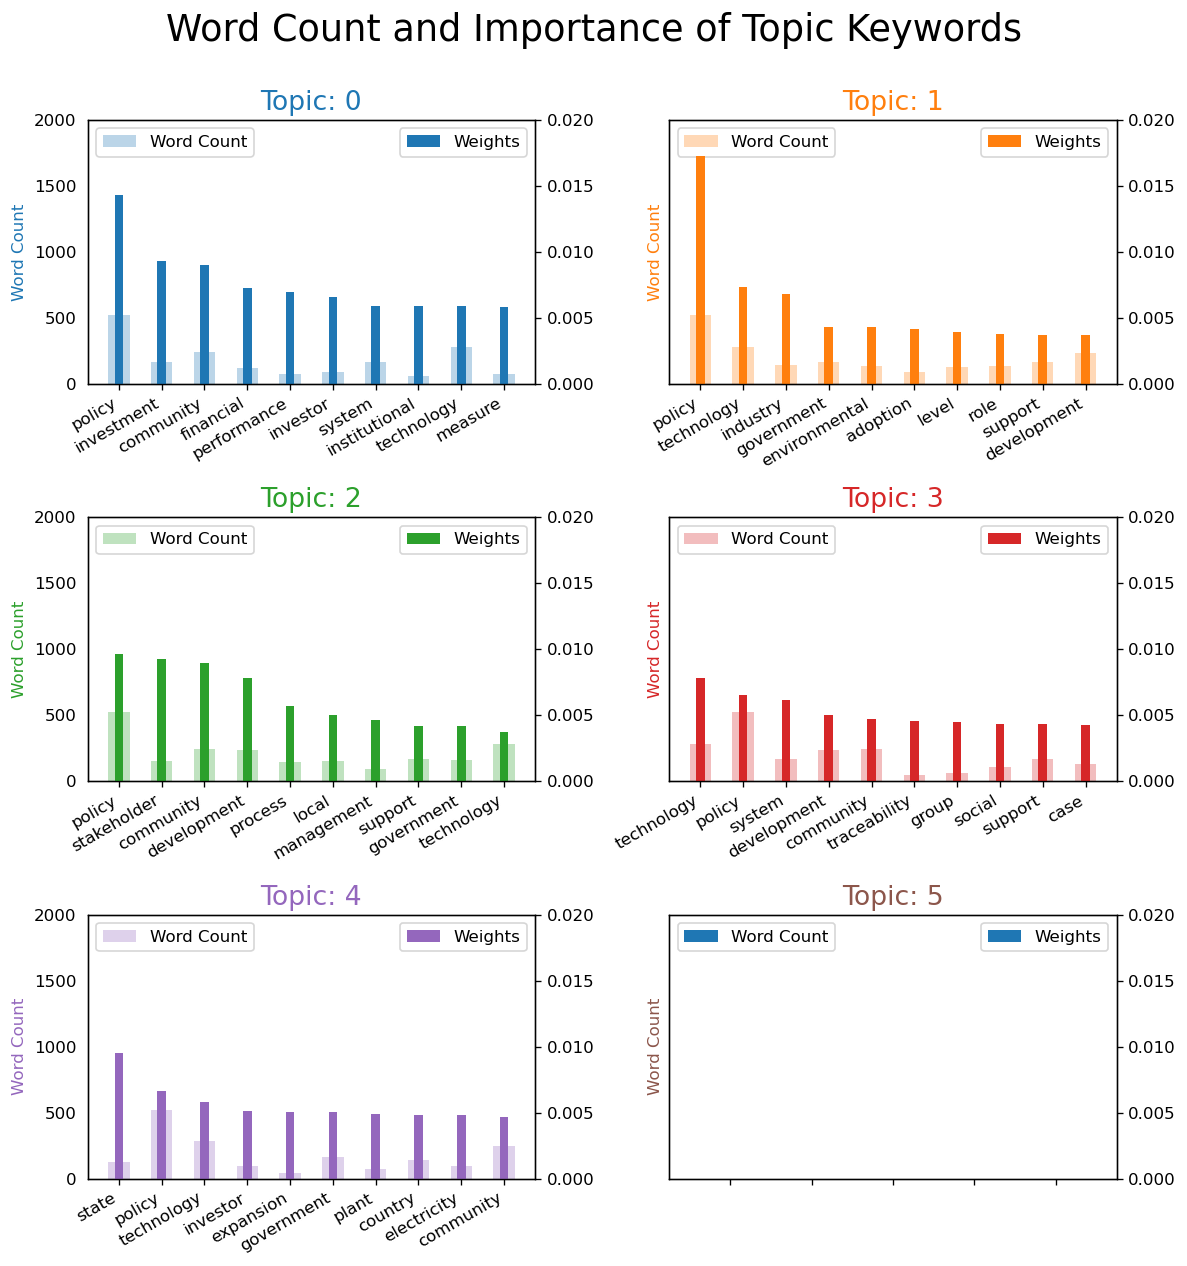

In [36]:
from collections import Counter
topics = lda_model.show_topics(formatted=False)
data_flat = [w for w_list in merged_content for w in w_list]
counter = Counter(data_flat)

out = []
for i, topic in topics:
    for word, weight in topic:
        out.append([word, i , weight, counter[word]])

df = pd.DataFrame(out, columns=['word', 'topic_id', 'importance', 'word_count'])        

# Plot Word Count and Weights of Topic Keywords
fig, axes = plt.subplots(3, 2, figsize=(10,10), sharey=True, dpi= 120)
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]
for i, ax in enumerate(axes.flatten()):
    ax.bar(x='word', height="word_count", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.5, alpha=0.3, label='Word Count')
    ax_twin = ax.twinx()
    ax_twin.bar(x='word', height="importance", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.2, label='Weights')
    ax.set_ylabel('Word Count', color=cols[i])
    ax_twin.set_ylim(0, 0.020); ax.set_ylim(0, 2000)
    ax.set_title('Topic: ' + str(i), color=cols[i], fontsize=16)
    ax.tick_params(axis='y', left=False)
    ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')
    ax.legend(loc='upper left'); ax_twin.legend(loc='upper right')

fig.tight_layout(w_pad=1)    
fig.suptitle('Word Count and Importance of Topic Keywords', fontsize=22, y=1.05)    
plt.show()


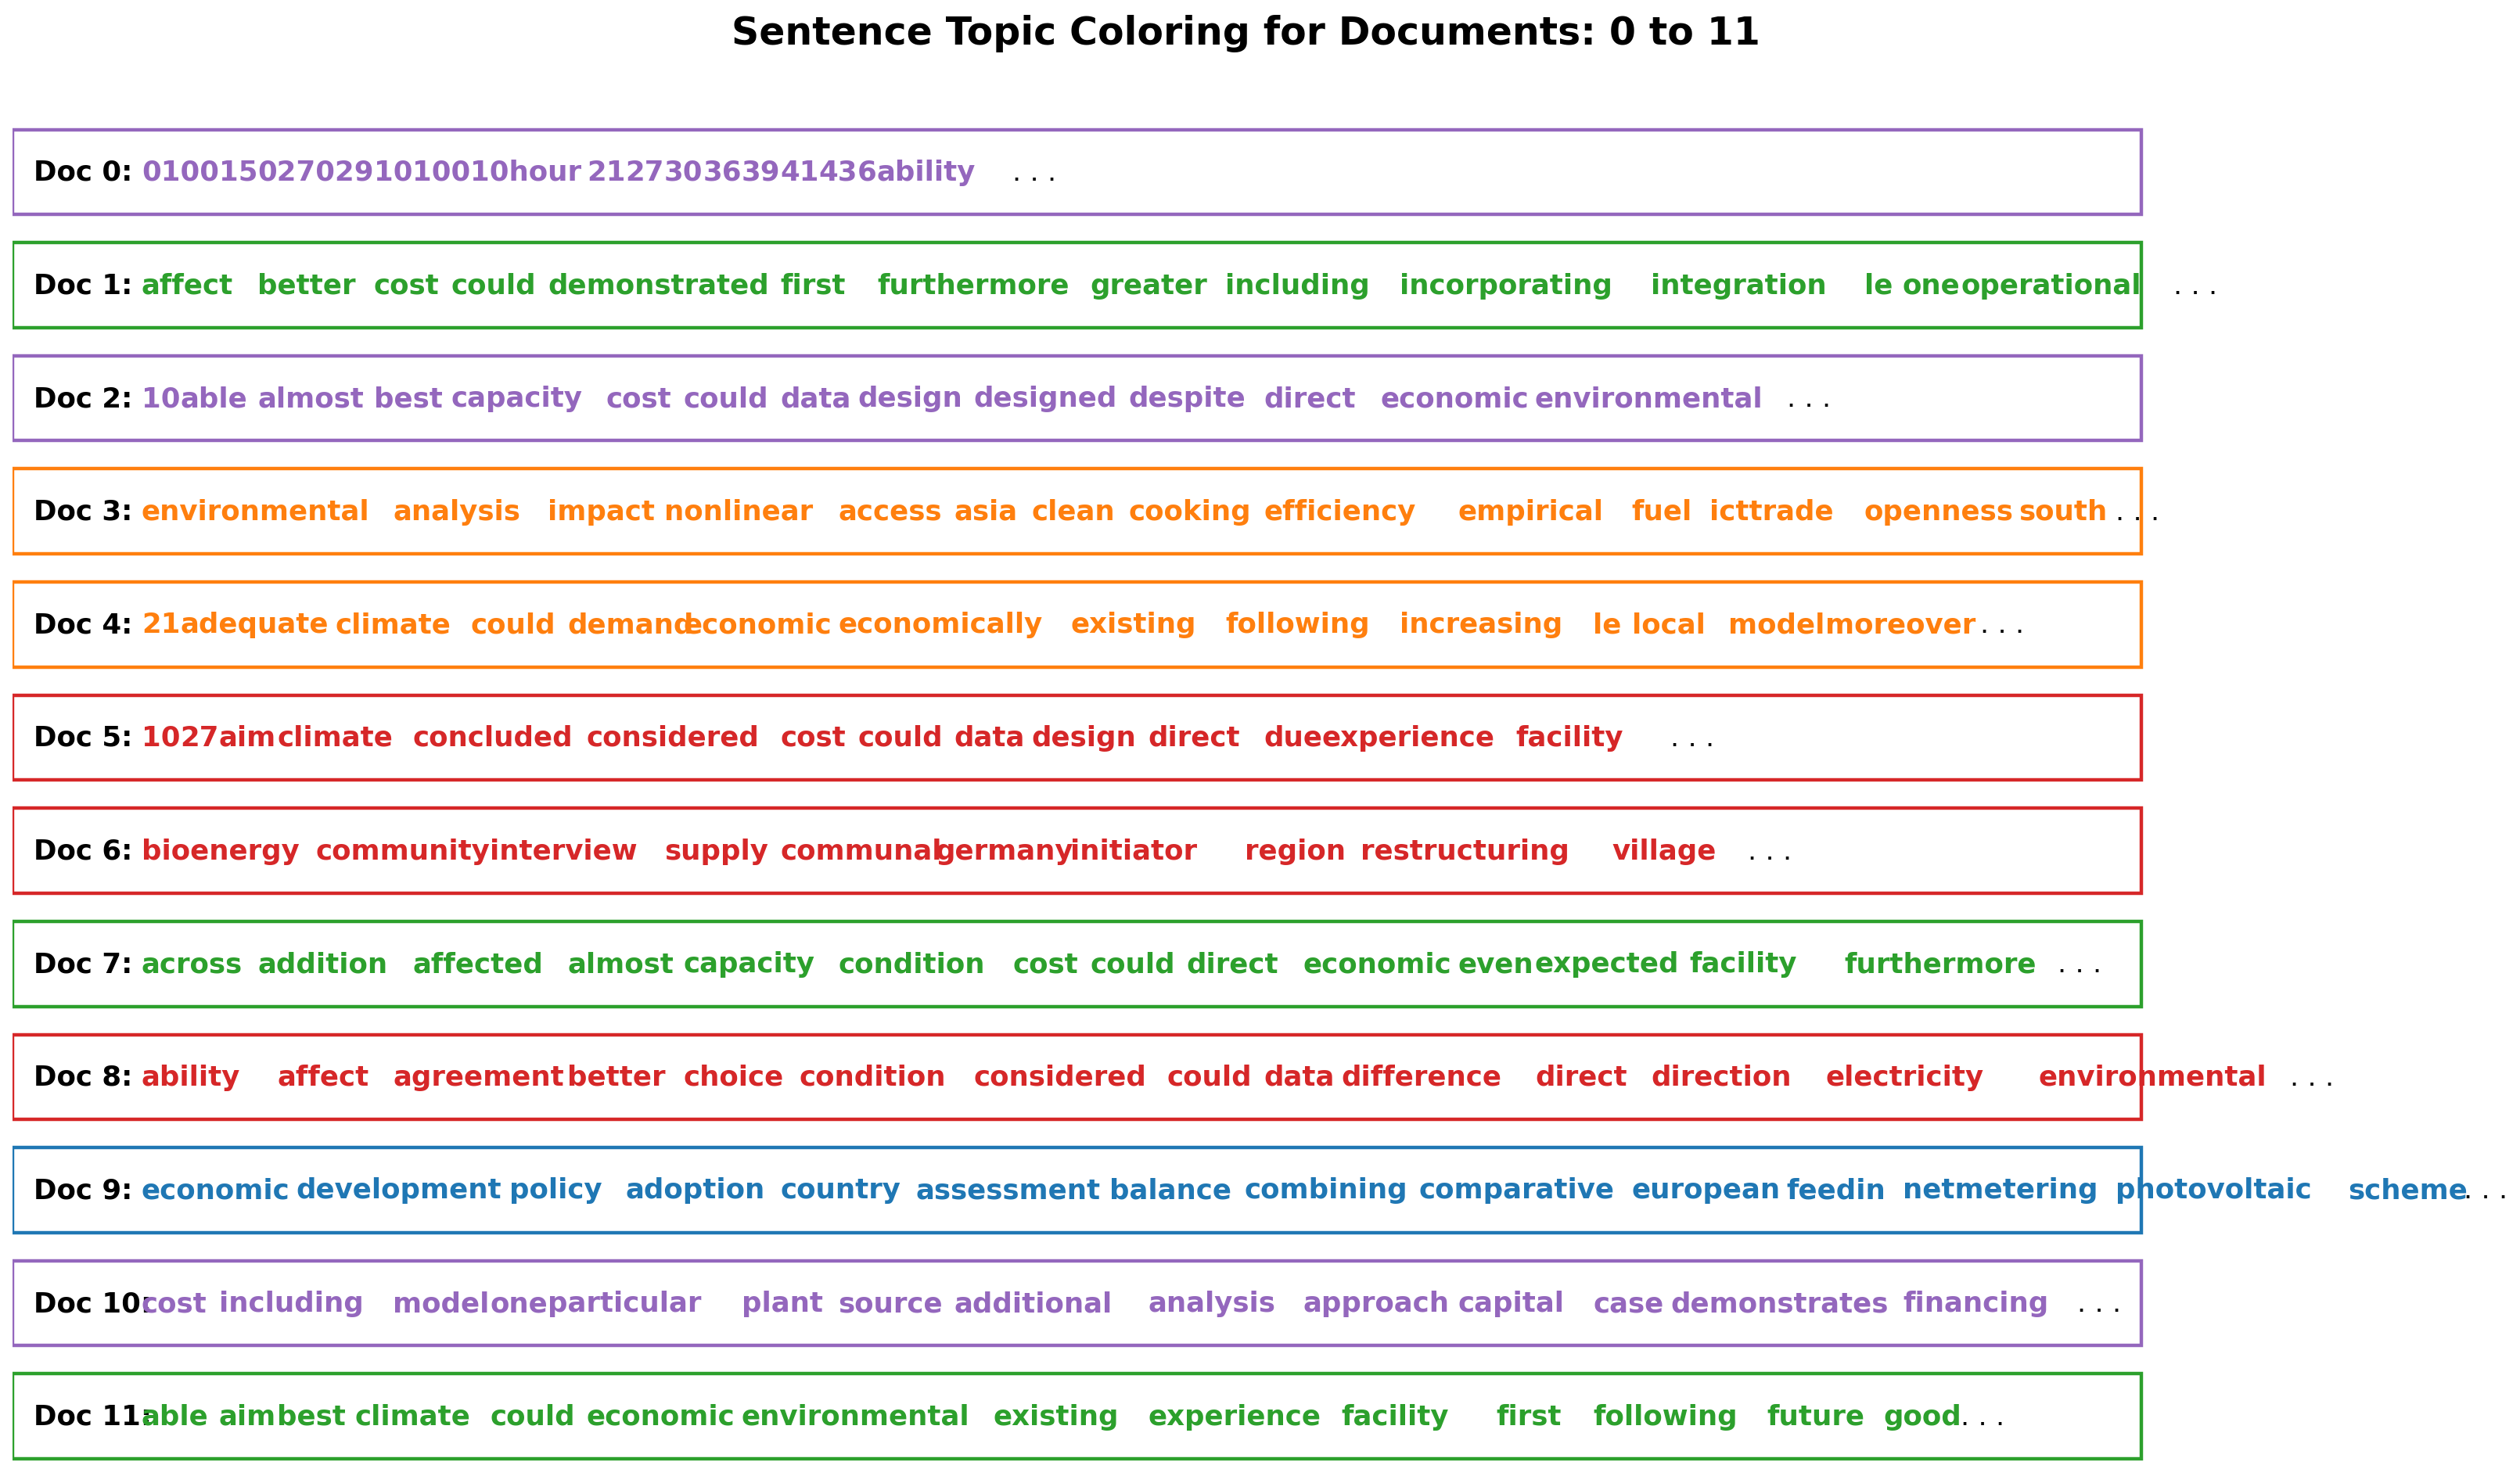

In [37]:
# Sentence Coloring of N Sentences
from matplotlib.patches import Rectangle

def sentences_chart(lda_model=lda_model, corpus=corpus, start = 0, end = 13):
    corp = corpus[start:end]
    mycolors = [color for name, color in mcolors.TABLEAU_COLORS.items()]

    fig, axes = plt.subplots(end-start, 1, figsize=(20, (end-start)*0.95), dpi=160)       
    axes[0].axis('off')
    for i, ax in enumerate(axes):
        if i > 0:
            corp_cur = corp[i-1] 
            topic_percs, wordid_topics, wordid_phivalues = lda_model[corp_cur]
            word_dominanttopic = [(lda_model.id2word[wd], topic[0]) for wd, topic in wordid_topics]    
            ax.text(0.01, 0.5, "Doc " + str(i-1) + ": ", verticalalignment='center',
                    fontsize=16, color='black', transform=ax.transAxes, fontweight=700)

            # Draw Rectange
            topic_percs_sorted = sorted(topic_percs, key=lambda x: (x[1]), reverse=True)
            ax.add_patch(Rectangle((0.0, 0.05), 0.99, 0.90, fill=None, alpha=1, 
                                   color=mycolors[topic_percs_sorted[0][0]], linewidth=2))

            word_pos = 0.06
            for j, (word, topics) in enumerate(word_dominanttopic):
                if j < 14:
                    ax.text(word_pos, 0.5, word,
                            horizontalalignment='left',
                            verticalalignment='center',
                            fontsize=16, color=mycolors[topics],
                            transform=ax.transAxes, fontweight=700)
                    word_pos += .009 * len(word)  # to move the word for the next iter
                    ax.axis('off')
            ax.text(word_pos, 0.5, '. . .',
                    horizontalalignment='left',
                    verticalalignment='center',
                    fontsize=16, color='black',
                    transform=ax.transAxes)       

    plt.subplots_adjust(wspace=0, hspace=0)
    plt.suptitle('Sentence Topic Coloring for Documents: ' + str(start) + ' to ' + str(end-2), fontsize=22, y=0.95, fontweight=700)
    plt.tight_layout()
    plt.show()

sentences_chart()  

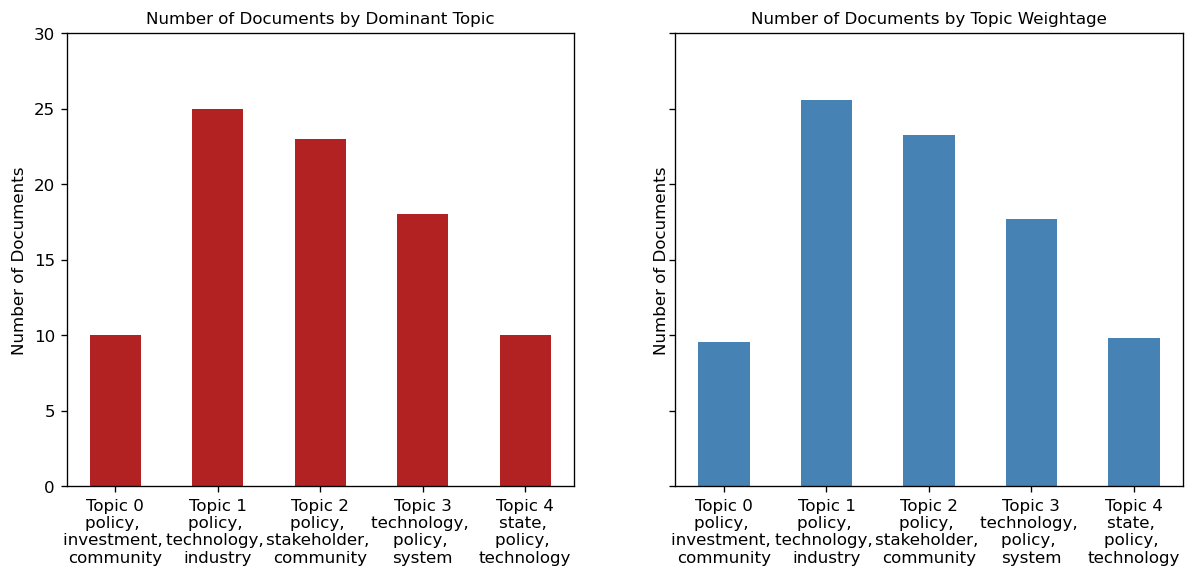

In [38]:
# Sentence Coloring of N Sentences
def topics_per_document(model, corpus, start=0, end=1):
    corpus_sel = corpus[start:end]
    dominant_topics = []
    topic_percentages = []
    for i, corp in enumerate(corpus_sel):
        topic_percs, wordid_topics, wordid_phivalues = model[corp]
        dominant_topic = sorted(topic_percs, key = lambda x: x[1], reverse=True)[0][0]
        dominant_topics.append((i, dominant_topic))
        topic_percentages.append(topic_percs)
    return(dominant_topics, topic_percentages)

dominant_topics, topic_percentages = topics_per_document(model=lda_model, corpus=corpus, end=-1)            

# Distribution of Dominant Topics in Each Document
df = pd.DataFrame(dominant_topics, columns=['Document_Id', 'Dominant_Topic'])
dominant_topic_in_each_doc = df.groupby('Dominant_Topic').size()
df_dominant_topic_in_each_doc = dominant_topic_in_each_doc.to_frame(name='count').reset_index()

# Total Topic Distribution by actual weight
topic_weightage_by_doc = pd.DataFrame([dict(t) for t in topic_percentages])
df_topic_weightage_by_doc = topic_weightage_by_doc.sum().to_frame(name='count').reset_index()

# Top 3 Keywords for each Topic
topic_top3words = [(i, topic) for i, topics in lda_model.show_topics(formatted=False) 
                                 for j, (topic, wt) in enumerate(topics) if j < 3]

df_top3words_stacked = pd.DataFrame(topic_top3words, columns=['topic_id', 'words'])
df_top3words = df_top3words_stacked.groupby('topic_id').agg(', \n'.join)
df_top3words.reset_index(level=0,inplace=True)

from matplotlib.ticker import FuncFormatter

# Plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5), dpi=120, sharey=True)

# Topic Distribution by Dominant Topics
ax1.bar(x='Dominant_Topic', height='count', data=df_dominant_topic_in_each_doc, width=.5, color='firebrick')
ax1.set_xticks(range(df_dominant_topic_in_each_doc.Dominant_Topic.unique().__len__()))
tick_formatter = FuncFormatter(lambda x, pos: 'Topic ' + str(x)+ '\n' + df_top3words.loc[df_top3words.topic_id==x, 'words'].values[0])
ax1.xaxis.set_major_formatter(tick_formatter)
ax1.set_title('Number of Documents by Dominant Topic', fontdict=dict(size=10))
ax1.set_ylabel('Number of Documents')
ax1.set_ylim(0, 30)


# Topic Distribution by Topic Weights
ax2.bar(x='index', height='count', data=df_topic_weightage_by_doc, width=.5, color='steelblue')
ax2.set_xticks(range(df_topic_weightage_by_doc.index.unique().__len__()))
ax2.xaxis.set_major_formatter(tick_formatter)
ax2.set_title('Number of Documents by Topic Weightage', fontdict=dict(size=10))
ax2.set_ylabel('Number of Documents')
ax1.set_ylim(0, 30)

plt.show()